# Required Libraries

In [1]:
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Data Loading

In [2]:
import random
import pandas as pd 
import numpy as np

id_1 = 7370
id_2 = 7524
id_3 = 0 

random_seed = id_1 + id_2 + id_3
random.seed(random_seed)

data_path = "data.csv"
output_path = "your_data.csv"

all_data = pd.read_csv(data_path) 
all_columns = all_data.columns.tolist()

target_column = 'smoking'  

all_columns.remove(target_column)
all_columns.remove('id')

features_indices = random.sample(range(len(all_columns)), 10)
features = [
    "hemoglobin",
    "height(cm)",
    "weight(kg)",
    "triglyceride",
    "Gtp",
    "serum creatinine",
    "HDL",
    "waist(cm)",
    "age",
    "ALT"
]
feature_indices = [all_data.columns.get_loc(feature) for feature in features]
features_indices = [0, 12, 10, 1, 15, 3, 13, 18, 4, 8]
selected_columns = [all_columns[i] for i in features_indices]
selected_columns = np.append(selected_columns, target_column)
data = all_data[selected_columns].copy()
# Show dimensions of loaded data to make sure that data are fully loaded
print("data shape:", data.shape)

data shape: (159256, 11)


# Outliers

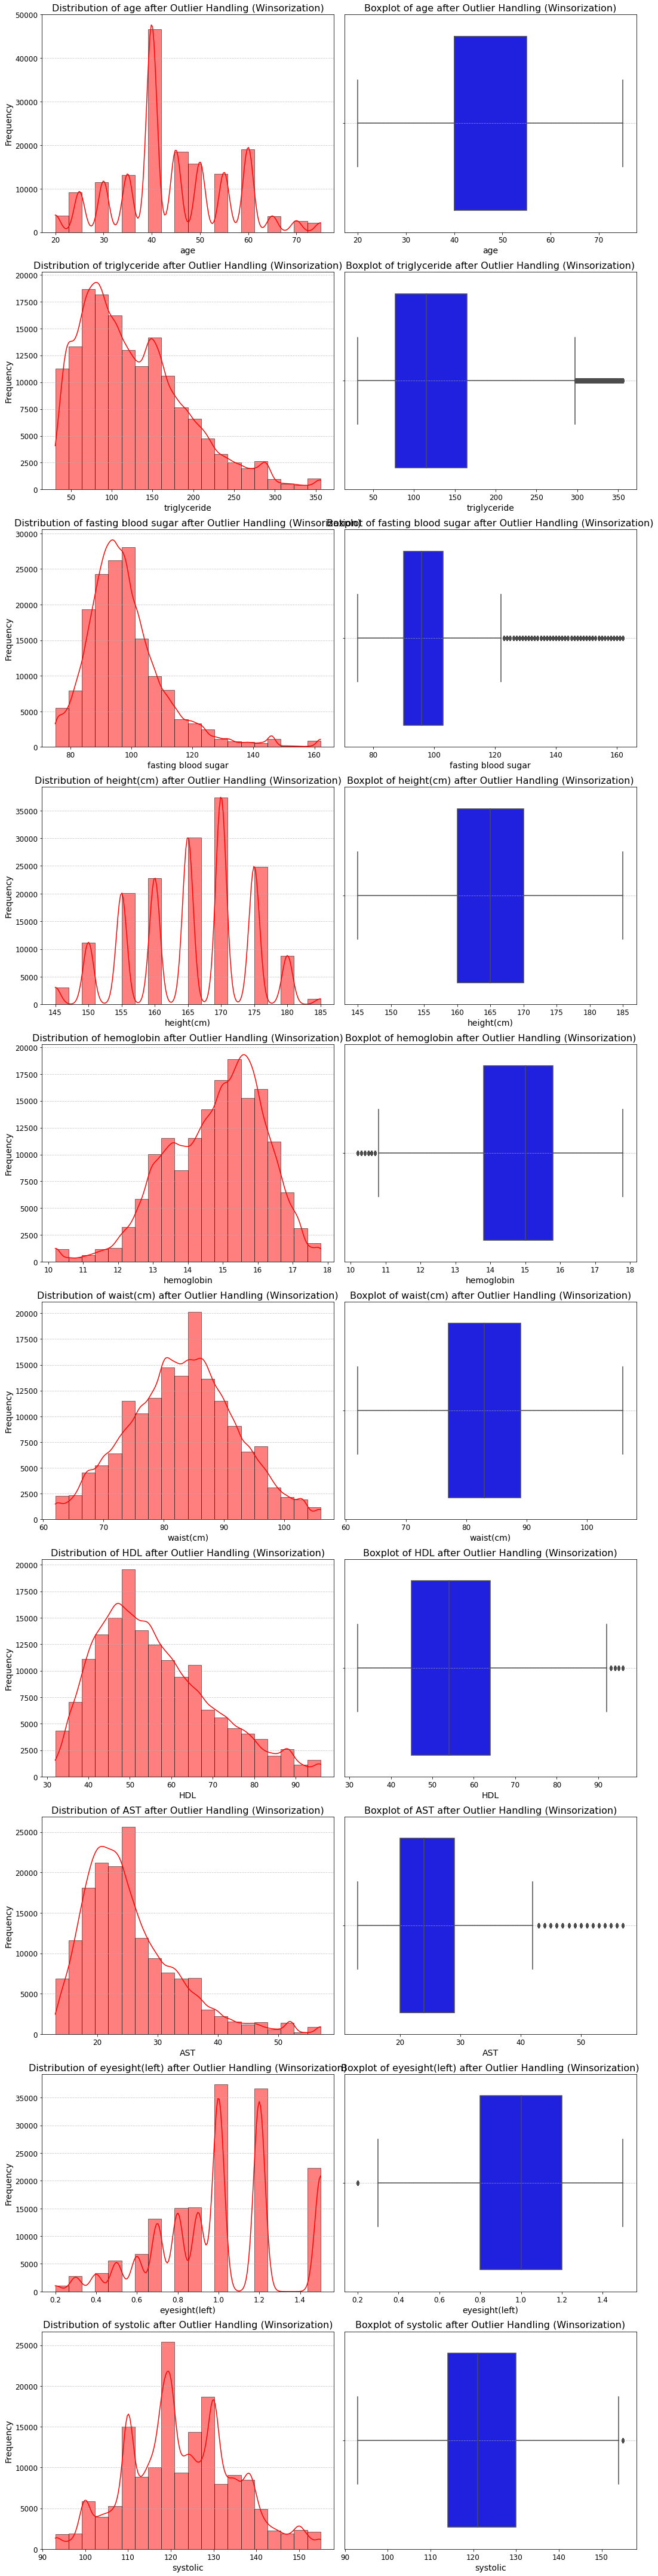

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats

# Assuming `data` is your DataFrame containing the features and the 'smoking' label

for feature in data.columns[:-1]:  # Exclude the last column (smoking label)
    # Calculate the 1st and 99th percentile for each feature
    lower_bound = data[feature].quantile(0.01)
    upper_bound = data[feature].quantile(0.99)

    # Winsorize the values within each class separately
    data.loc[data['smoking'] == 0, feature] = mstats.winsorize(data.loc[data['smoking'] == 0, feature], limits=[0.01, 0.01])
    data.loc[data['smoking'] == 1, feature] = mstats.winsorize(data.loc[data['smoking'] == 1, feature], limits=[0.01, 0.01])

# Visualize the distribution of each feature after outlier handling using winsorization
fig, axes = plt.subplots(data.shape[1] - 1, 2, figsize=(15, (data.shape[1] - 1) * 6))

# Visualize the distribution of each feature after handling outliers
for i, feature in enumerate(data.columns[:-1]):
    # Distribution plot with KDE
    sns.histplot(data[feature], bins=20, kde=True, color='red', edgecolor='black', linewidth=0.5, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {feature} after Outlier Handling (Winsorization)', fontsize=16)
    axes[i, 0].set_xlabel(feature, fontsize=14)
    axes[i, 0].set_ylabel('Frequency', fontsize=14)
    axes[i, 0].tick_params(labelsize=12)
    axes[i, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # Box plot for identifying outliers
    sns.boxplot(x=data[feature], color='blue', ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot of {feature} after Outlier Handling (Winsorization)', fontsize=16)
    axes[i, 1].set_xlabel(feature, fontsize=14)
    axes[i, 1].tick_params(labelsize=12)
    axes[i, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the subplots
plt.show()


# Skewed Features

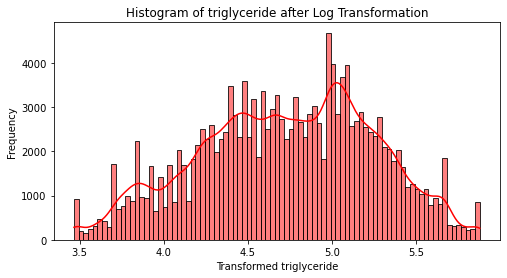

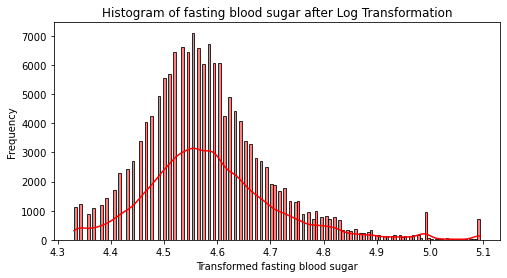

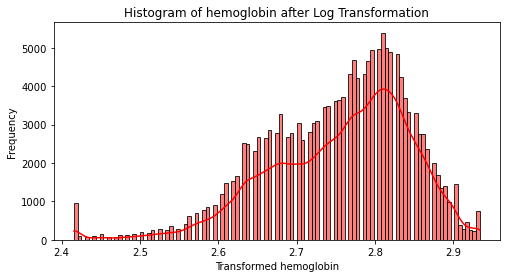

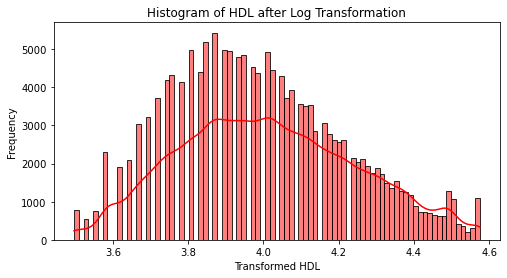

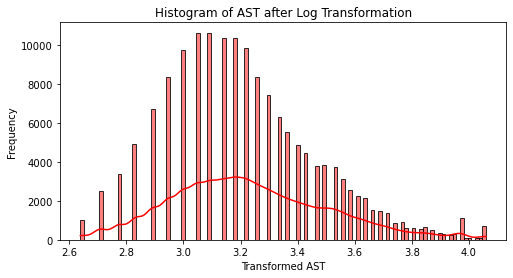

In [4]:
# Calculate skewness for all numeric features
numeric_features = data.select_dtypes(include=[np.number])
skewness = numeric_features.apply(lambda x: stats.skew(x))

# Assume threshold = 0.5
skew_threshold = 0.5

# Filter features with skewness above the threshold
skewed_features = skewness[abs(skewness) > skew_threshold]

# Apply log transformation to skewed features
for feature in skewed_features.index:
    data[feature] = np.log1p(data[feature])

# Create histograms for each transformed feature
for feature in skewed_features.index:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True, color='red', edgecolor='black', linewidth=0.8)
    plt.title(f'Histogram of {feature} after Log Transformation')
    plt.xlabel(f'Transformed {feature}')
    plt.ylabel('Frequency')
    plt.show()

# Feature generation

## Binning of most effective features in the label

In [5]:
# List of features to be binned
features_to_bin = ['hemoglobin', 'height(cm)', 'triglyceride', 'age', 'waist(cm)']

# Function to perform binning for a specific feature
def bin_feature(df, feature, num_bins=5):
    bins = pd.cut(df[feature], bins=num_bins, labels=False)
    df[feature + '_binned'] = bins.astype(str)
    return df

# Binning for each specified feature
for feature in features_to_bin:
    data = bin_feature(data, feature)

# Display the modified DataFrame
data.head()

,age,triglyceride,fasting blood sugar,height(cm),hemoglobin,waist(cm),HDL,AST,eyesight(left),systolic,smoking,hemoglobin_binned,height(cm)_binned,triglyceride_binned,age_binned,waist(cm)_binned
0,55,5.707110,4.553877,165,2.862201,81.0,3.713572,3.135494,0.5,135,1,4,2,4,3,2
1,70,4.025352,4.990433,165,2.844909,89.0,4.060443,3.332205,0.6,146,0,4,2,1,4,3
2,20,5.288267,4.382027,170,2.912351,81.0,3.828641,3.332205,0.4,118,1,4,3,3,0,2
3,35,5.318120,4.521789,180,2.827314,103.0,3.663562,3.044522,1.5,131,0,3,4,3,1,4
4,30,4.477337,4.521789,165,2.797281,80.5,3.806662,2.995732,1.5,121,1,3,2,2,0,2


## Create Interaction Terms between features

In [6]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd

# Assuming 'data' is your DataFrame with features (X) and target variable 'smoking' (y)
# Replace 'data' with the actual name of your DataFrame if it's different

# Features with strong correlations
top_features = ['hemoglobin', 'height(cm)', 'triglyceride', 'waist(cm)']

# Extract top features and target variable
X_top = data[top_features]
y = data['smoking']

# Create interaction terms using PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = pd.DataFrame(poly.fit_transform(X_top), columns=poly.get_feature_names_out(X_top.columns))

# Replace original features with interaction terms in the 'data' DataFrame
data = pd.concat([data, X_interactions], axis=1)

# Display the modified DataFrame with interaction terms
data.head()

,age,triglyceride,fasting blood sugar,height(cm),hemoglobin,waist(cm),HDL,AST,eyesight(left),systolic,...,hemoglobin,height(cm),triglyceride,waist(cm),hemoglobin height(cm),hemoglobin triglyceride,hemoglobin waist(cm),height(cm) triglyceride,height(cm) waist(cm),triglyceride waist(cm)
0,55,5.707110,4.553877,165,2.862201,81.0,3.713572,3.135494,0.5,135,...,2.862201,165.0,5.707110,81.0,472.263145,16.334896,231.838271,941.673194,13365.0,462.275931
1,70,4.025352,4.990433,165,2.844909,89.0,4.060443,3.332205,0.6,146,...,2.844909,165.0,4.025352,89.0,469.410048,11.451761,253.196935,664.183029,14685.0,358.256300
2,20,5.288267,4.382027,170,2.912351,81.0,3.828641,3.332205,0.4,118,...,2.912351,170.0,5.288267,81.0,495.099613,15.401288,235.900404,899.005395,13770.0,428.349629
3,35,5.318120,4.521789,180,2.827314,103.0,3.663562,3.044522,1.5,131,...,2.827314,180.0,5.318120,103.0,508.916452,15.035993,291.213303,957.261599,18540.0,547.766359
4,30,4.477337,4.521789,165,2.797281,80.5,3.806662,2.995732,1.5,121,...,2.797281,165.0,4.477337,80.5,461.551420,12.524371,225.181147,738.760574,13282.5,360.425614


# Data Spliting

In [7]:
# Assuming sample_df is your DataFrame with the selected features
train_data, test_data = train_test_split(data, test_size=0.2, random_state=random_seed)
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=random_seed)

# Display the shapes of the resulting sets
print("Training Data: ", train_data.shape)
print("Training Data: ", valid_data.shape)
print("Cross Validation Data: ", test_data.shape)

Training Data:  (101923, 26)
Training Data:  (25481, 26)
Cross Validation Data:  (31852, 26)


In [8]:
# Extract features (X) and labels (y)
X_train, y_train = train_data.drop(columns=['smoking']), train_data['smoking']
X_valid, y_valid = valid_data.drop(columns=['smoking']), valid_data['smoking']
X_test, y_test = test_data.drop(columns=['smoking']), test_data['smoking']

# Display the shapes of the resulting sets
print("Training Data - X_train shape:", X_train.shape)
print("Training Data - y_train shape:", y_train.shape)
print("Cross Validation Data - X_val shape:", X_valid.shape)
print("Cross Validation Data - y_val shape:", y_valid.shape)
print("Testing Data - X_test shape:", X_test.shape)
print("Testing Data - y_test shape:", y_test.shape)

Training Data - X_train shape: (101923, 25)
Training Data - y_train shape: (101923,)
Cross Validation Data - X_val shape: (25481, 25)
Cross Validation Data - y_val shape: (25481,)
Testing Data - X_test shape: (31852, 25)
Testing Data - y_test shape: (31852,)


# Scaling

In [9]:
# Initialize MinMaxScaler
#scaler = MinMaxScaler()
scaler = StandardScaler()
# Fit and transform on training data
X_train = scaler.fit_transform(X_train)

# Transform validation and test data
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Save Normalized Data

In [10]:
# Convert arrays to DataFrames
X_train = pd.DataFrame(X_train)
X_valid = pd.DataFrame(X_valid)
X_test = pd.DataFrame(X_test)


# Save the DataFrames to CSV files
X_train.to_csv('X_train.csv', index=False)
X_valid.to_csv('X_valid.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_valid.to_csv('y_valid.csv', index=False)
y_test.to_csv('y_test.csv', index=False)